# Import Library

In [1]:
pip install yfinance


In [2]:
# Load data
import yfinance as yf
import pandas as pd
import numpy as np
import os
from datetime import datetime
import time

#EDA
from statsmodels.tsa.seasonal import seasonal_decompose

# Data preparation
from sklearn.preprocessing import MinMaxScaler # Import MinMaxScaler

# Modelling
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Inference & save model
import json
from datetime import datetime
import tensorflow as tf
import joblib


# Load data

In [3]:
def get_usdjpy_data(start_date='2015-01-01', end_date=None, csv_path='usdjpy_data.csv', force_download=False, delay=5):
    if end_date is None:
        end_date = datetime.today().strftime('%Y-%m-%d')

    if not force_download and os.path.exists(csv_path):
        print(f"Membaca data dari cache: {csv_path}")
        data = pd.read_csv(csv_path, index_col=0, parse_dates=True)
    else:
        print(f"Mengunduh data USD/JPY dari Yahoo Finance: {start_date} sampai {end_date}")
        time.sleep(delay)
        data = yf.download('JPY=X', start=start_date, end=end_date)

        # Ambil hanya 5 kolom yang diinginkan
        columns_to_keep = ['Close', 'High', 'Low', 'Open', 'Volume']
        data = data[columns_to_keep]

        # Ganti nama kolom sesuai urutan (agar mudah pada data preparation)
        data.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

        data.to_csv(csv_path)
        print(f"Data disimpan ke {csv_path}")

    return data

data = get_usdjpy_data(end_date=None)  # end_date=None untuk hari ini


Mengunduh data USD/JPY dari Yahoo Finance: 2015-01-01 sampai 2025-06-09
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Data disimpan ke usdjpy_data.csv


# EDA

## Cek missing value & duplikat

In [4]:
data.isnull().sum()

,0
Close,0
High,0
Low,0
Open,0
Volume,0


In [5]:
data.duplicated().sum()

np.int64(0)

## Meneliti 5 data terakhir

In [6]:
data.tail()

,Close,High,Low,Open,Volume
Date,,,,,
2025-06-02,143.815002,143.796997,142.546005,143.815002,0
2025-06-03,142.451996,143.973007,142.423004,142.451996,0
2025-06-04,143.837006,144.348999,142.903000,143.837006,0
2025-06-05,142.731995,143.947998,142.587006,142.731995,0
2025-06-06,143.542007,145.074997,143.544998,143.542007,0


## Meneliti dimensi dataset

In [7]:
print("Dimensi dataset:", data.shape)

Dimensi dataset: (2716, 5)


## Meneliti nilai

In [8]:
data.describe()

,Close,High,Low,Open,Volume
count,2716.000000,2716.000000,2716.000000,2716.000000,2716.0
mean,121.321691,121.733385,120.880441,121.322859,0.0
std,16.442087,16.551353,16.308766,16.441306,0.0
min,99.905998,100.379997,99.572998,99.892998,0.0
25%,109.152250,109.462997,108.825253,109.153250,0.0
50%,113.348499,113.668999,112.978001,113.351997,0.0
75%,134.647003,135.275253,133.977497,134.647003,0.0
max,161.621002,161.942001,161.300003,161.621002,0.0


### Insight :    
- Nilai volume 0, karena pasangan USD sering tidak ditampilkan data nya oleh beberapa pihak, salah satunya platform sumber kami yaitu Yahoo Finance
- Volume akan dihapus karena tidak memiliki pengaruh pada time series, karena tidak ada datanya.

## Visualisasi Tren Harga

<Axes: title={'center': 'USD/JPY Closing Price'}, xlabel='Date'>

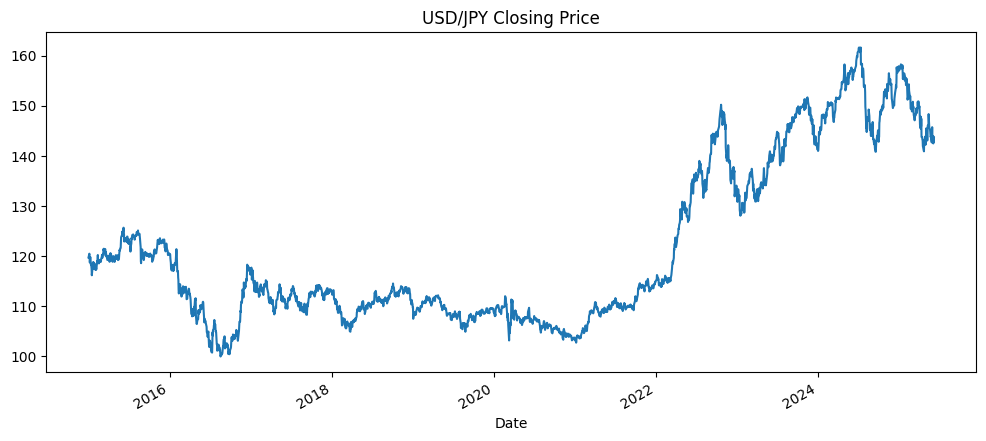

In [9]:
data['Close'].plot(figsize=(12, 5), title='USD/JPY Closing Price')

## Seasonality & Trend

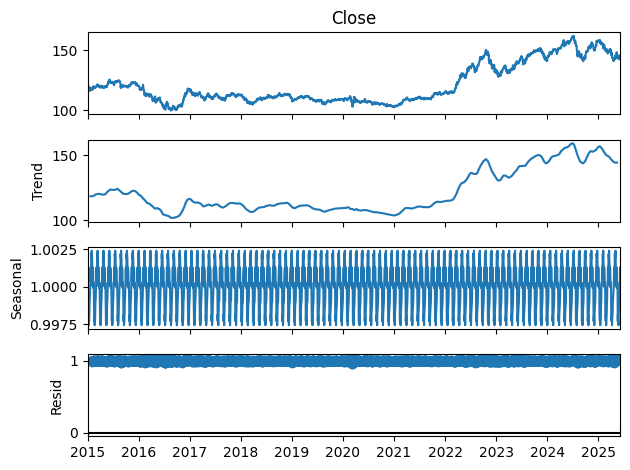

In [10]:
result = seasonal_decompose(data['Close'], model='multiplicative', period=30)
result.plot();

### Insight :     
- USD/JPY memiliki fluktuasi tren jangka panjang
- Ada kenaikan tren signifikan antara 2021 hingga 2025, meskipun terdapat penurunan sebentar di tahun 2023.
- Fluktuasi seasonal cukup kecil dalam skala.
- Terdapat fase tren naik yang panjang, cocok untuk digunakan dalam strategi long-term trading atau hedging.

## Boxplot

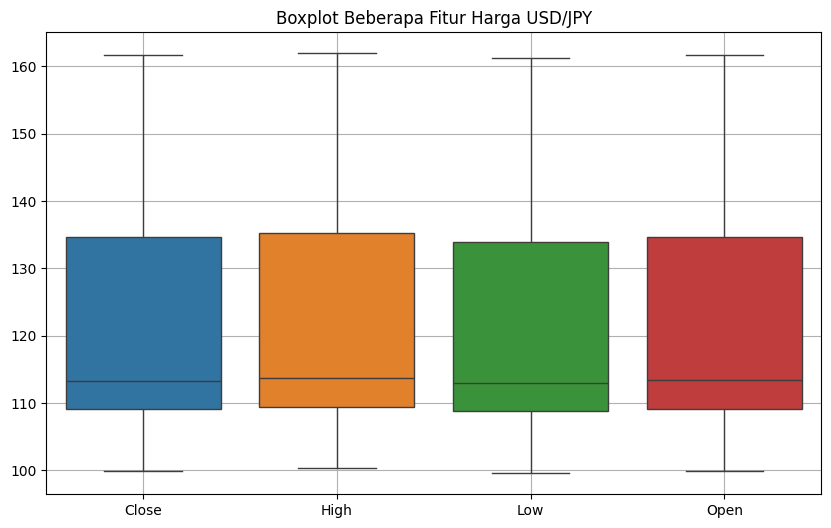

In [11]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=data[['Close', 'High', 'Low', 'Open']])
plt.title("Boxplot Beberapa Fitur Harga USD/JPY")
plt.grid(True)
plt.show()

### Insight :
- Distribusi merata dan bersih

# Data Preprocessing

In [12]:
# 1. Memastikan index dataframe adalah date
print(data.index)

DatetimeIndex(['2015-01-01', '2015-01-02', '2015-01-05', '2015-01-06',
               '2015-01-07', '2015-01-08', '2015-01-09', '2015-01-12',
               '2015-01-13', '2015-01-14',
               ...
               '2025-05-26', '2025-05-27', '2025-05-28', '2025-05-29',
               '2025-05-30', '2025-06-02', '2025-06-03', '2025-06-04',
               '2025-06-05', '2025-06-06'],
              dtype='datetime64[ns]', name='Date', length=2716, freq=None)


In [13]:
# 2. Menghapus kolom volume
data.drop(columns=['Volume'], inplace=True)

# 3. Hitung perubahan harga harian (Price Change)
data['Price_Change'] = data['Close'].diff().fillna(0)

# 4. Klasifikasi perubahan harga (Price Range Class)
def classify_price_range(change):
    if change <= -0.01:
        return 'turunjauh'
    elif change <= -0.001:
        return 'turundekat'
    elif change > 0.01:
        return 'naikjauh'
    elif change > 0.001:
        return 'naikdekat'
    else:
        return 'stabil'

# 5. Klasifikasi range high-low harian (Volatilitas)
def classify_high_low_range(row):
    hl_range = row['High'] - row['Low']
    if hl_range > 0.01:
        return 'rangebesar'
    elif hl_range > 0.001:
        return 'rangesedang'
    elif hl_range > 0.0001:
        return 'rangekecil'
    else:
        return 'rangetipis'

data['Price_Range_Class'] = data['Price_Change'].apply(classify_price_range)
data['High_Low_Range_Class'] = data.apply(classify_high_low_range, axis=1)

# 6. Hitung RSI
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / (avg_loss + 1e-10)
    return 100 - (100 / (1 + rs))

data['RSI'] = compute_rsi(data['Close'])

# 7. Moving Averages
data['MA_5'] = data['Close'].rolling(window=5).mean()
data['MA_10'] = data['Close'].rolling(window=10).mean()

# 8. Hitung MACD
def compute_macd(series, fast_period=12, slow_period=26, signal_period=9):
    exp1 = series.ewm(span=fast_period, adjust=False).mean()
    exp2 = series.ewm(span=slow_period, adjust=False).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal_period, adjust=False).mean()
    return macd, signal_line

data['MACD'], data['MACD_Signal'] = compute_macd(data['Close'])

# 9. Drop NA rows (karena MA dan RSI awal akan kosong)
data.dropna(inplace=True)

In [14]:
# Meneliti 5 data terakhir setelah menambahkan fitur baru
print("Data dengan fitur baru:")
data.tail()

Data dengan fitur baru:


,Close,High,Low,Open,Price_Change,Price_Range_Class,High_Low_Range_Class,RSI,MA_5,MA_10,MACD,MACD_Signal
Date,,,,,,,,,,,,
2025-06-02,143.815002,143.796997,142.546005,143.815002,0.035995,naikjauh,rangebesar,29.299082,144.024603,143.990604,-0.362986,-0.328997
2025-06-03,142.451996,143.973007,142.423004,142.451996,-1.363007,turunjauh,rangebesar,27.810795,143.984003,143.738303,-0.481584,-0.359514
2025-06-04,143.837006,144.348999,142.903000,143.837006,1.385010,naikjauh,rangebesar,38.225255,143.916003,143.689203,-0.458529,-0.379317
2025-06-05,142.731995,143.947998,142.587006,142.731995,-1.105011,turunjauh,rangebesar,38.008805,143.323001,143.586902,-0.523390,-0.408132
2025-06-06,143.542007,145.074997,143.544998,143.542007,0.810013,naikjauh,rangebesar,42.980529,143.275601,143.555302,-0.503626,-0.427231


# Data Preparation

In [15]:
# 1. Membuat target NAIK/TURUN t+1 s.d. t+5 (senin-jum'at)
for offset in range(1, 6):
    data[f'Close_t+{offset}'] = data['Close'].shift(-offset)
    data[f'Target_t+{offset}'] = (data[f'Close_t+{offset}'] > data['Close']).astype(int)

data.dropna(inplace=True)

In [16]:
# 2. Normalisasi numerik
scaler = MinMaxScaler()
data[['Close', 'RSI', 'MA_5', 'MA_10', 'MACD']] = scaler.fit_transform(data[['Close', 'RSI', 'MA_5', 'MA_10', 'MACD']])

# 3. One-hot encoding
data = pd.get_dummies(data, columns=['Price_Range_Class', 'High_Low_Range_Class'])

# 4. Sequence LSTM
window_size = 90  # Bisa dioptimalkan nanti
features = data.drop(columns=[f'Close_t+{i}' for i in range(1, 6)] + [f'Target_t+{i}' for i in range(1, 6)]).values
targets = data[[f'Target_t+{i}' for i in range(1, 6)]].values

X, y = [], []
for i in range(len(features) - window_size):
    X.append(features[i:i+window_size])
    y.append(targets[i+window_size])

X = np.array(X).astype(np.float32)
y = np.array(y).astype(np.int32)

In [17]:
# Meneliti 5 data terakhir setelah normalisasi
print("Data dengan fitur baru:")
data.tail()

Data dengan fitur baru:


,Close,High,Low,Open,Price_Change,RSI,MA_5,MA_10,MACD,MACD_Signal,...,Target_t+4,Close_t+5,Target_t+5,Price_Range_Class_naikdekat,Price_Range_Class_naikjauh,Price_Range_Class_stabil,Price_Range_Class_turundekat,Price_Range_Class_turunjauh,High_Low_Range_Class_rangebesar,High_Low_Range_Class_rangetipis
Date,,,,,,,,,,,,,,,,,,,,,
2025-05-26,0.696119,143.033005,142.233994,142.867004,-0.990997,0.439100,0.715185,0.738345,0.513376,-0.222732,...,1,143.815002,1,False,False,False,False,True,True,False
2025-05-27,0.692684,144.449005,142.130997,142.654999,-0.212006,0.457693,0.707600,0.729029,0.492038,-0.277132,...,1,142.451996,0,False,False,False,False,True,True,False
2025-05-28,0.717346,145.063995,143.869003,144.177002,1.522003,0.491436,0.707106,0.723509,0.497343,-0.314532,...,0,143.837006,0,False,True,False,False,False,True,False
2025-05-29,0.741975,146.251007,144.067001,145.697006,1.520004,0.460809,0.713455,0.721939,0.523433,-0.314348,...,0,142.731995,0,False,True,False,False,False,True,False
2025-05-30,0.710897,144.401001,143.444000,143.779007,-1.917999,0.390118,0.713197,0.718918,0.517973,-0.320500,...,0,143.542007,0,False,False,False,False,True,True,False


In [18]:
# 5. Menyiapkan data untuk model klasifikasi dan regresi
data_cls = data.copy()
data_reg = data.copy()

In [19]:
# 6. Target regresi (harga penutupan)
regression_targets = data_reg[[f'Close_t+{i}' for i in range(1, 6)]].values

# Menggunakan fitur yang sama
X_reg = []
y_reg = []
for i in range(len(features) - window_size):
    X_reg.append(features[i:i+window_size])
    y_reg.append(regression_targets[i+window_size])

X_reg = np.array(X_reg).astype(np.float32)
y_reg = np.array(y_reg).astype(np.float32)

# Modelling

## Klasifikasi (Naik/Turun)

### Split Data

In [20]:
# Split Data
X_cls = np.array(X).astype(np.float32)
y_cls = np.array(y).astype(np.int32)

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls
    )

### Build Model

In [21]:
# Build Model
model_cls = Sequential([
    Input(shape=(X.shape[1], X.shape[2])),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(5, activation='sigmoid')  # output 5 hari
])

model_cls.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_cls.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 90, 64)         │        20,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 90, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,573 (131.14 KB)

 Trainable params: 33,573 (131.14 KB)

 Non-trainable params: 0 (0.00 B)

### Train

In [22]:
# Checkpoint untuk menyimpan model terbaik
checkpoint_cls = ModelCheckpoint('best_model_cls.h5', monitor='val_loss', save_best_only=True, verbose=1)

# Train model
history = model_cls.fit(
    X_train_cls, y_train_cls,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[checkpoint_cls],
    verbose=1
)

Epoch 1/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.1539 - loss: 0.6958
Epoch 1: val_loss improved from inf to 0.69114, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 12s 82ms/step - accuracy: 0.1533 - loss: 0.6960 - val_accuracy: 0.0598 - val_loss: 0.6911
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.1302 - loss: 0.6925
Epoch 2: val_loss did not improve from 0.69114
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.1300 - loss: 0.6925 - val_accuracy: 0.0598 - val_loss: 0.6913
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.2677 - loss: 0.6968
Epoch 3: val_loss improved from 0.69114 to 0.69099, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.2670 - loss: 0.6968 - val_accuracy: 0.0622 - val_loss: 0.6910
Epoch 4/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.0826 - loss: 0.6939
Epoch 4: val_loss improved from 0.69099 to 0.69070, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.0830 - loss: 0.6939 - val_accuracy: 0.0622 - val_loss: 0.6907
Epoch 5/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.0811 - loss: 0.6932
Epoch 5: val_loss did not improve from 0.69070
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.0816 - loss: 0.6932 - val_accuracy: 0.1220 - val_loss: 0.6914
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.2607 - loss: 0.6942
Epoch 6: val_loss did not improve from 0.69070
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.2604 - loss: 0.6942 - val_accuracy: 0.0622 - val_loss: 0.6913
Epoch 7/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.1151 - loss: 0.6923
Epoch 7: val_loss did not improve from 0.69070
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.1151 - loss: 0.6924 - val_accuracy: 0.1029 - val_loss: 0.6912
Epoch 8/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.1784 - loss: 0.6927
Epoch 8: val_loss did not improve from 0.69070
53/5

### Evaluation

In [23]:
# Load model terbaik dari file checkpoint
model = load_model('best_model_cls.h5')

y_pred_probs = model.predict(X_test_cls)
y_pred = (y_pred_probs > 0.5).astype(int)

from sklearn.metrics import classification_report

for i in range(5):
    print(f"\n📈 t+{i+1} Classification Report:")
    print(classification_report(y_test_cls[:, i], y_pred[:, i]))

# Evaluasi loss dan akurasi
loss, acc = model.evaluate(X_test_cls, y_test_cls, verbose=0)
print(f"\nTest Loss: {loss:.4f}, Test Accuracy: {acc:.4f}")



17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step

📈 t+1 Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       248
           1       0.52      1.00      0.69       274

    accuracy                           0.52       522
   macro avg       0.26      0.50      0.34       522
weighted avg       0.28      0.52      0.36       522


📈 t+2 Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       247
           1       0.53      1.00      0.69       275

    accuracy                           0.53       522
   macro avg       0.26      0.50      0.35       522
weighted avg       0.28      0.53      0.36       522


📈 t+3 Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       246
           1       0.53      1.00      0.69       276

    accuracy                           0.53       52

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


Test Loss: 0.6915, Test Accuracy: 0.0594


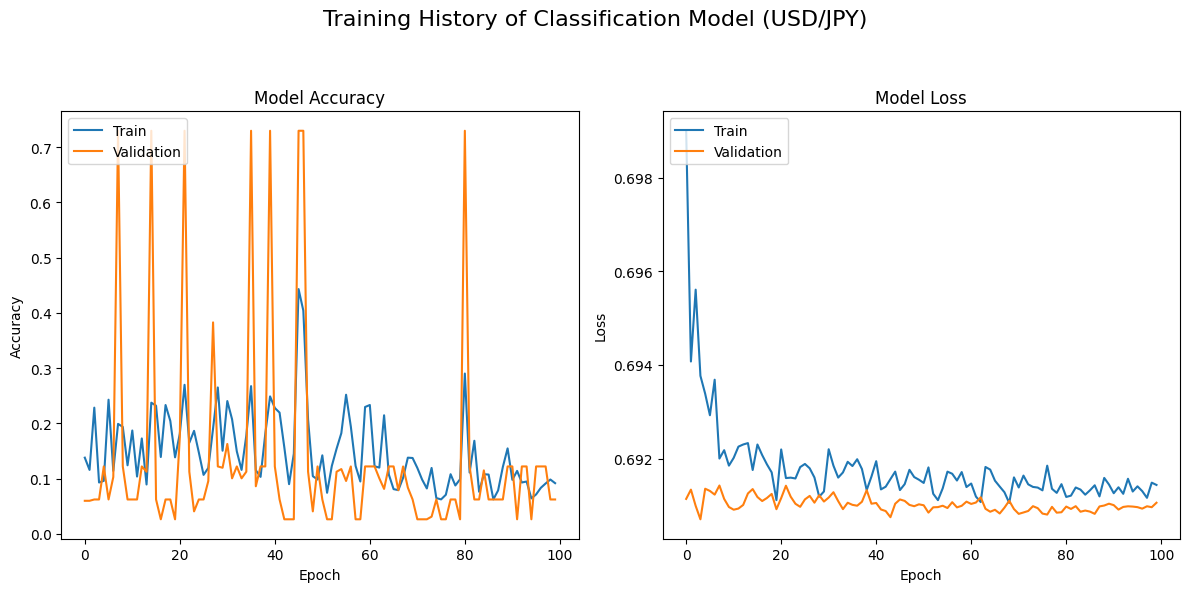

In [24]:
# Visualize training history (Classification Model)
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Tambahkan title utama
plt.suptitle('Training History of Classification Model (USD/JPY)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.93])  # beri ruang untuk suptitle
plt.show()


Grafik overfitting, namun yang digunakan adalah dari checkpoint best_model

### Save Model

In [25]:
# Save Model
model_cls.save('USDJPY_model_cls.h5')
# Save Model
joblib.dump(scaler, 'USDJPY_scaler.save')

['USDJPY_scaler.save']

## Regresi

### Split Data

In [26]:
# Split data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42, shuffle=False
    )


### Build Model

In [27]:
# Arsitektur model LSTM untuk regresi 5 output
model_reg = Sequential([
    LSTM(64, return_sequences=False, input_shape=(X_train_reg.shape[1], X_train_reg.shape[2])),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(5)  # Output untuk Close_t+1 hingga Close_t+5
])

model_reg.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_reg.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        20,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,237 (90.77 KB)

 Trainable params: 23,237 (90.77 KB)

 Non-trainable params: 0 (0.00 B)

### Train

In [28]:
# Checkpoint untuk menyimpan model terbaik
checkpoint_reg = ModelCheckpoint('best_model_reg.h5', monitor='val_loss', save_best_only=True, verbose=1)

history_reg = model_reg.fit(
    X_train_reg, y_train_reg,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[checkpoint_reg],
    verbose=1
)


Epoch 1/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 11932.9775 - mae: 109.1248
Epoch 1: val_loss improved from inf to 15254.55664, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 11923.8945 - mae: 109.0822 - val_loss: 15254.5566 - val_mae: 123.0567
Epoch 2/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 10037.2305 - mae: 99.9517 
Epoch 2: val_loss improved from 15254.55664 to 11170.54102, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 10009.2891 - mae: 99.8045 - val_loss: 11170.5410 - val_mae: 105.0037
Epoch 3/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 6489.2012 - mae: 79.8180
Epoch 3: val_loss improved from 11170.54102 to 6259.82617, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 6453.7505 - mae: 79.5762 - val_loss: 6259.8262 - val_mae: 77.8448
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 2828.7297 - mae: 51.2887
Epoch 4: val_loss improved from 6259.82617 to 2729.48511, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 2817.4426 - mae: 51.1640 - val_loss: 2729.4851 - val_mae: 50.0142
Epoch 5/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 842.9923 - mae: 25.6705
Epoch 5: val_loss improved from 2729.48511 to 1170.91980, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 835.0683 - mae: 25.5124 - val_loss: 1170.9198 - val_mae: 31.3529
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 238.3901 - mae: 12.3438
Epoch 6: val_loss improved from 1170.91980 to 669.70819, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 237.6011 - mae: 12.3204 - val_loss: 669.7082 - val_mae: 23.1218
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 135.2744 - mae: 9.1732
Epoch 7: val_loss improved from 669.70819 to 549.49915, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 134.9993 - mae: 9.1645 - val_loss: 549.4991 - val_mae: 20.8980
Epoch 8/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 109.5391 - mae: 8.2456
Epoch 8: val_loss improved from 549.49915 to 523.97839, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 109.2765 - mae: 8.2368 - val_loss: 523.9784 - val_mae: 20.4118
Epoch 9/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 100.6202 - mae: 7.9059
Epoch 9: val_loss improved from 523.97839 to 511.12561, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 100.6174 - mae: 7.9068 - val_loss: 511.1256 - val_mae: 20.1198
Epoch 10/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 97.3966 - mae: 7.8279
Epoch 10: val_loss improved from 511.12561 to 510.90503, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 97.4127 - mae: 7.8287 - val_loss: 510.9050 - val_mae: 20.1183
Epoch 11/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 90.8099 - mae: 7.5780
Epoch 11: val_loss did not improve from 510.90503
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 90.8412 - mae: 7.5780 - val_loss: 539.2912 - val_mae: 20.9025
Epoch 12/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 98.4769 - mae: 7.7352
Epoch 12: val_loss improved from 510.90503 to 477.03394, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 98.4086 - mae: 7.7342 - val_loss: 477.0339 - val_mae: 19.2805
Epoch 13/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 95.3294 - mae: 7.7522
Epoch 13: val_loss did not improve from 477.03394
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 95.3562 - mae: 7.7537 - val_loss: 504.6983 - val_mae: 19.9670
Epoch 14/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 97.6515 - mae: 7.8160
Epoch 14: val_loss did not improve from 477.03394
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 97.6695 - mae: 7.8172 - val_loss: 491.8983 - val_mae: 19.6777
Epoch 15/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 94.6228 - mae: 7.7756
Epoch 15: val_loss did not improve from 477.03394
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 94.7870 - mae: 7.7800 - val_loss: 489.9182 - val_mae: 19.6909
Epoch 16/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 92.6708 - mae: 7.5987
Epoch 16: val_loss did not improve from 477.03394
53/53 ━━━━━━━━━━━━━━━━━━━━ 3

53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 98.6955 - mae: 7.9082 - val_loss: 458.9582 - val_mae: 18.8789
Epoch 18/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 90.5125 - mae: 7.6547
Epoch 18: val_loss did not improve from 458.95816
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 90.6019 - mae: 7.6571 - val_loss: 467.8067 - val_mae: 19.1272
Epoch 19/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 90.5039 - mae: 7.5997
Epoch 19: val_loss did not improve from 458.95816
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 90.5559 - mae: 7.6000 - val_loss: 466.5806 - val_mae: 19.2857
Epoch 20/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 95.6438 - mae: 7.7737
Epoch 20: val_loss improved from 458.95816 to 446.97018, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 95.7567 - mae: 7.7766 - val_loss: 446.9702 - val_mae: 18.6847
Epoch 21/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 95.9478 - mae: 7.7853
Epoch 21: val_loss did not improve from 446.97018
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 95.8768 - mae: 7.7814 - val_loss: 535.8590 - val_mae: 21.0676
Epoch 22/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 94.3042 - mae: 7.8084
Epoch 22: val_loss improved from 446.97018 to 421.82996, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 94.2284 - mae: 7.8028 - val_loss: 421.8300 - val_mae: 18.0725
Epoch 23/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 93.3078 - mae: 7.6088
Epoch 23: val_loss improved from 421.82996 to 412.74628, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 93.1790 - mae: 7.6055 - val_loss: 412.7463 - val_mae: 17.8389
Epoch 24/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 87.7787 - mae: 7.4573
Epoch 24: val_loss did not improve from 412.74628
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 87.8014 - mae: 7.4588 - val_loss: 421.4048 - val_mae: 18.1050
Epoch 25/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 88.9566 - mae: 7.5768
Epoch 25: val_loss did not improve from 412.74628
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 88.9646 - mae: 7.5763 - val_loss: 416.1817 - val_mae: 17.9824
Epoch 26/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 91.4420 - mae: 7.6882
Epoch 26: val_loss did not improve from 412.74628
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 91.4750 - mae: 7.6887 - val_loss: 427.6963 - val_mae: 18.4664
Epoch 27/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 88.7437 - mae: 7.5523
Epoch 27: val_loss improved from 412.74628 to 407.43750, saving model to best_

53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 88.7646 - mae: 7.5538 - val_loss: 407.4375 - val_mae: 17.8409
Epoch 28/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 103.7694 - mae: 8.1174
Epoch 28: val_loss improved from 407.43750 to 403.13876, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 103.6739 - mae: 8.1133 - val_loss: 403.1388 - val_mae: 17.6533
Epoch 29/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 94.4312 - mae: 7.7673
Epoch 29: val_loss improved from 403.13876 to 384.11124, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 94.4515 - mae: 7.7678 - val_loss: 384.1112 - val_mae: 17.1387
Epoch 30/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 89.1370 - mae: 7.5167
Epoch 30: val_loss improved from 384.11124 to 379.02008, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 89.1388 - mae: 7.5169 - val_loss: 379.0201 - val_mae: 17.0627
Epoch 31/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 83.5787 - mae: 7.2795
Epoch 31: val_loss did not improve from 379.02008
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 83.7296 - mae: 7.2850 - val_loss: 386.6803 - val_mae: 17.3388
Epoch 32/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 94.5311 - mae: 7.6993
Epoch 32: val_loss did not improve from 379.02008
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 94.3349 - mae: 7.6926 - val_loss: 390.3271 - val_mae: 17.2976
Epoch 33/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 86.8850 - mae: 7.3584
Epoch 33: val_loss improved from 379.02008 to 362.64914, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 86.9429 - mae: 7.3609 - val_loss: 362.6491 - val_mae: 16.2782
Epoch 34/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 94.1947 - mae: 7.7688
Epoch 34: val_loss did not improve from 362.64914
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 94.1913 - mae: 7.7676 - val_loss: 371.0406 - val_mae: 16.9222
Epoch 35/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 93.5796 - mae: 7.5687
Epoch 35: val_loss did not improve from 362.64914
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 93.4499 - mae: 7.5643 - val_loss: 373.9694 - val_mae: 16.7369
Epoch 36/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 87.5468 - mae: 7.4561
Epoch 36: val_loss improved from 362.64914 to 352.13409, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 87.5866 - mae: 7.4592 - val_loss: 352.1341 - val_mae: 16.3918
Epoch 37/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 78.1123 - mae: 6.8619
Epoch 37: val_loss improved from 352.13409 to 316.49036, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 78.1714 - mae: 6.8659 - val_loss: 316.4904 - val_mae: 15.2768
Epoch 38/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 90.7654 - mae: 7.6211
Epoch 38: val_loss did not improve from 316.49036
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 90.7047 - mae: 7.6186 - val_loss: 327.1962 - val_mae: 15.8731
Epoch 39/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 82.1640 - mae: 7.1532
Epoch 39: val_loss improved from 316.49036 to 280.32144, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 82.0989 - mae: 7.1510 - val_loss: 280.3214 - val_mae: 14.3479
Epoch 40/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 77.6763 - mae: 6.9366
Epoch 40: val_loss improved from 280.32144 to 247.62032, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 77.6507 - mae: 6.9378 - val_loss: 247.6203 - val_mae: 13.2763
Epoch 41/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 82.0689 - mae: 7.1643
Epoch 41: val_loss did not improve from 247.62032
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 82.0181 - mae: 7.1640 - val_loss: 264.6196 - val_mae: 14.1770
Epoch 42/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 83.9431 - mae: 7.4049
Epoch 42: val_loss did not improve from 247.62032
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 83.8775 - mae: 7.4014 - val_loss: 269.6115 - val_mae: 14.1910
Epoch 43/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 76.6462 - mae: 6.9841
Epoch 43: val_loss did not improve from 247.62032
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 76.6697 - mae: 6.9856 - val_loss: 265.2067 - val_mae: 13.6200
Epoch 44/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 72.6350 - mae: 6.7571
Epoch 44: val_loss did not improve from 247.62032
53/53 ━━━━━━━━━━━━━━━━━━━━ 2

53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 71.6820 - mae: 6.7021 - val_loss: 230.3376 - val_mae: 12.5678
Epoch 46/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 75.5288 - mae: 6.9593
Epoch 46: val_loss improved from 230.33760 to 199.80428, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 75.4669 - mae: 6.9537 - val_loss: 199.8043 - val_mae: 11.6608
Epoch 47/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 77.8720 - mae: 7.0945
Epoch 47: val_loss did not improve from 199.80428
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 77.8382 - mae: 7.0917 - val_loss: 222.2752 - val_mae: 12.7333
Epoch 48/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 80.8889 - mae: 7.1706
Epoch 48: val_loss did not improve from 199.80428
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 80.8656 - mae: 7.1708 - val_loss: 262.9875 - val_mae: 14.5097
Epoch 49/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 77.1062 - mae: 6.8418
Epoch 49: val_loss did not improve from 199.80428
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 77.0150 - mae: 6.8416 - val_loss: 212.5820 - val_mae: 12.0669
Epoch 50/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 75.5161 - mae: 6.9471
Epoch 50: val_loss did not improve from 199.80428
53/53 ━━━━━━━━━━━━━━━━━━━━ 3

53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 75.1813 - mae: 6.9197 - val_loss: 181.1973 - val_mae: 11.0484
Epoch 52/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 69.8386 - mae: 6.6353
Epoch 52: val_loss did not improve from 181.19728
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 69.8805 - mae: 6.6369 - val_loss: 202.9678 - val_mae: 11.7315
Epoch 53/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 73.8554 - mae: 6.8610
Epoch 53: val_loss improved from 181.19728 to 180.04723, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 73.8583 - mae: 6.8615 - val_loss: 180.0472 - val_mae: 11.0240
Epoch 54/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 73.1080 - mae: 6.8602
Epoch 54: val_loss did not improve from 180.04723
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 73.0982 - mae: 6.8581 - val_loss: 202.0690 - val_mae: 12.3971
Epoch 55/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 75.9970 - mae: 6.9352
Epoch 55: val_loss did not improve from 180.04723
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 75.9219 - mae: 6.9305 - val_loss: 186.0459 - val_mae: 11.2247
Epoch 56/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 70.1796 - mae: 6.6079
Epoch 56: val_loss improved from 180.04723 to 168.35442, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 70.2282 - mae: 6.6139 - val_loss: 168.3544 - val_mae: 10.7004
Epoch 57/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 75.8751 - mae: 6.9498
Epoch 57: val_loss did not improve from 168.35442
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 75.9274 - mae: 6.9521 - val_loss: 212.7619 - val_mae: 12.9678
Epoch 58/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 76.8558 - mae: 7.0197
Epoch 58: val_loss did not improve from 168.35442
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 76.7846 - mae: 7.0160 - val_loss: 192.3607 - val_mae: 11.5449
Epoch 59/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 72.0868 - mae: 6.6667
Epoch 59: val_loss did not improve from 168.35442
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 72.1028 - mae: 6.6696 - val_loss: 180.5595 - val_mae: 11.0564
Epoch 60/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 75.6066 - mae: 6.9272
Epoch 60: val_loss did not improve from 168.35442
53/53 ━━━━━━━━━━━━━━━━━━━━ 4

53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 71.2156 - mae: 6.7081 - val_loss: 156.8999 - val_mae: 10.3811
Epoch 69/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 65.1103 - mae: 6.3154
Epoch 69: val_loss improved from 156.89987 to 151.09653, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 65.1932 - mae: 6.3213 - val_loss: 151.0965 - val_mae: 10.1114
Epoch 70/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 69.2275 - mae: 6.6805
Epoch 70: val_loss improved from 151.09653 to 144.40144, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 69.2516 - mae: 6.6818 - val_loss: 144.4014 - val_mae: 9.7386
Epoch 71/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 65.0112 - mae: 6.4069
Epoch 71: val_loss did not improve from 144.40144
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 65.0689 - mae: 6.4109 - val_loss: 146.5081 - val_mae: 9.8048
Epoch 72/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 65.8323 - mae: 6.5415
Epoch 72: val_loss did not improve from 144.40144
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 65.9021 - mae: 6.5453 - val_loss: 150.4380 - val_mae: 9.9710
Epoch 73/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 71.5919 - mae: 6.7399
Epoch 73: val_loss improved from 144.40144 to 126.05637, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 71.5650 - mae: 6.7385 - val_loss: 126.0564 - val_mae: 9.0400
Epoch 74/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 70.6707 - mae: 6.7975
Epoch 74: val_loss did not improve from 126.05637
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 70.6111 - mae: 6.7938 - val_loss: 130.0728 - val_mae: 9.3992
Epoch 75/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 72.7769 - mae: 6.7816
Epoch 75: val_loss did not improve from 126.05637
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 72.7597 - mae: 6.7813 - val_loss: 139.9913 - val_mae: 9.6829
Epoch 76/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 65.9094 - mae: 6.5396
Epoch 76: val_loss did not improve from 126.05637
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 65.9562 - mae: 6.5409 - val_loss: 158.6570 - val_mae: 10.4858
Epoch 77/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 70.6206 - mae: 6.6571
Epoch 77: val_loss did not improve from 126.05637
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 3

53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 62.3631 - mae: 6.3407 - val_loss: 124.7313 - val_mae: 8.9083
Epoch 99/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 61.4534 - mae: 6.1968
Epoch 99: val_loss improved from 124.73133 to 120.33102, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 61.5059 - mae: 6.2008 - val_loss: 120.3310 - val_mae: 8.9601
Epoch 100/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 65.2946 - mae: 6.5295
Epoch 100: val_loss did not improve from 120.33102
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 65.2579 - mae: 6.5274 - val_loss: 146.8388 - val_mae: 9.8821


### Evaluation

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 612.4301 - mae: 24.2043
Test Loss (MSE): 709.642212, Test MAE: 26.132755
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


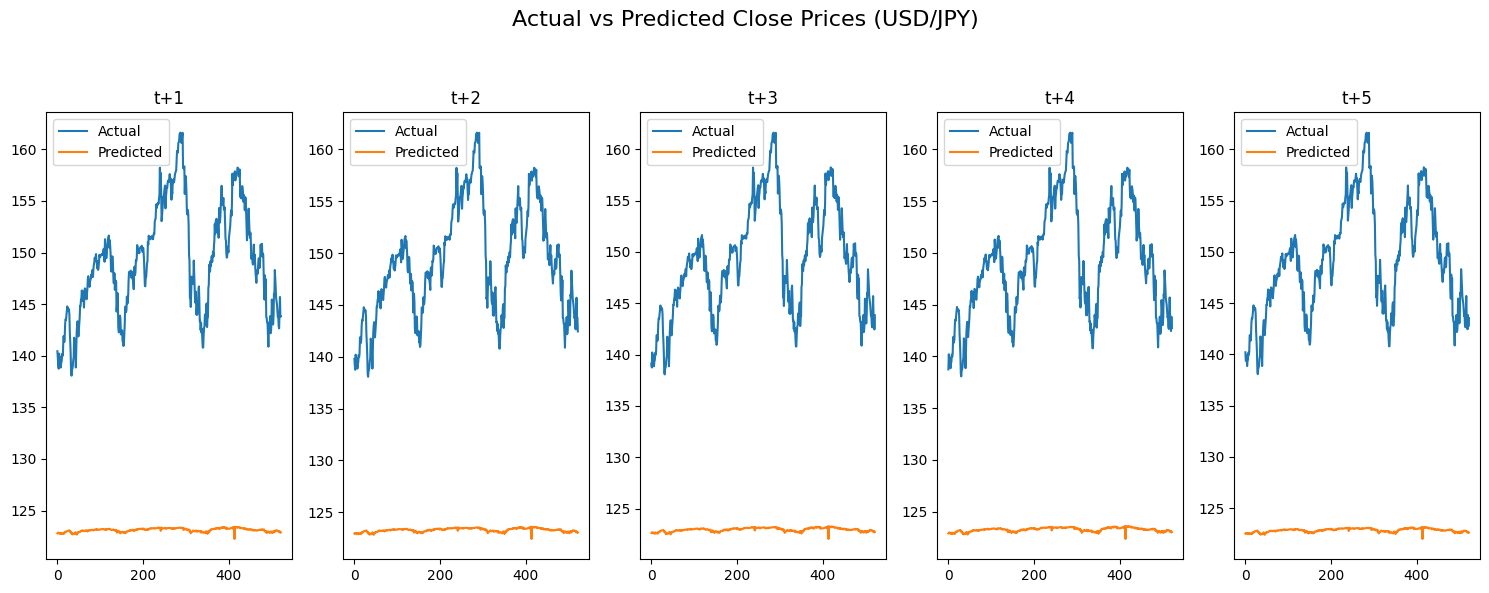

In [29]:
# Evaluasi
loss, mae = model_reg.evaluate(X_test_reg, y_test_reg)
print(f"Test Loss (MSE): {loss:.6f}, Test MAE: {mae:.6f}")

# Plot prediksi vs aktual
y_pred_reg = model_reg.predict(X_test_reg)

plt.figure(figsize=(15, 6))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.plot(y_test_reg[:, i], label='Actual')
    plt.plot(y_pred_reg[:, i], label='Predicted')
    plt.title(f"t+{i+1}")  # judul untuk masing-masing subplot
    plt.legend()

plt.suptitle("Actual vs Predicted Close Prices (USD/JPY)", fontsize=16)  # satu judul utama
plt.tight_layout(rect=[0, 0, 1, 0.93])  # agar tidak menabrak suptitle
plt.show()


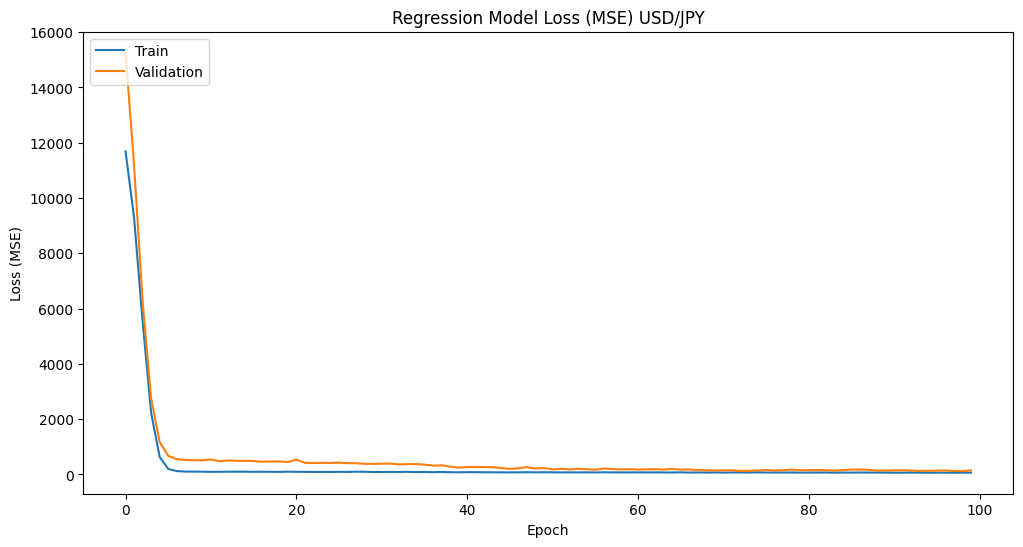

In [30]:
# Visualize training history (Regression Model)
plt.figure(figsize=(12, 6))

# Plot training & validation loss values for regression
plt.plot(history_reg.history['loss'])
plt.plot(history_reg.history['val_loss'])
plt.title('Regression Model Loss (MSE) USD/JPY')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

### Save Model

In [31]:
# Save model regresi
model_reg.save('USDJPY_model_reg.h5')

# Inferensi

In [34]:
# Ambil window terakhir dari array features yang sudah disiapkan sebelumnya
latest_sequence = features[-window_size:]  # Shape (90, features)

# Ubah ke bentuk batch
X_latest = np.expand_dims(latest_sequence, axis=0).astype(np.float32)

# Get the last actual close price BEFORE scaling
last_actual_close = data['Close'].iloc[-window_size - 1] # Get the close price from the row *before* the latest sequence starts

# Prediksi probabilitas naik (tetap menggunakan model_cls)
y_pred_probs_cls = model_cls.predict(X_latest)
y_pred_cls = (y_pred_probs_cls > 0.5).astype(int)

# Prediksi harga penutupan (scaled, tetap menggunakan model_reg)
y_pred_price_scaled = model_reg.predict(X_latest)

# Kembalikan skala harga ke bentuk aslinya
close_min = scaler.data_min_[0]
close_max = scaler.data_max_[0]

# Function to inverse transform manual only for the Close column
def inverse_minmax(value, vmin, vmax):
    return value * (vmax - vmin) + vmin - 7547

predicted_actual_prices = []
results = []
reference_price = last_actual_close # Start with the last actual close as the reference for t+1

print("📊 Prediksi Klasifikasi (Naik/Turun Relative to Previous Day's Predicted Close):")
print("📈 Prediksi Harga Penutupan (Close) Pekan Depan:")

for i in range(5):
    # Inverse transform the predicted scaled price for the current day (t+i+1)
    predicted_scaled_price = y_pred_price_scaled[0, i]
    predicted_original_price_absolute = inverse_minmax(predicted_scaled_price, close_min, close_max)

    # Determine classification relative to the reference price (previous day's close or predicted close)
    classification = "Naik" if predicted_original_price_absolute > reference_price else "Turun"

    print(f"t+{i+1}: {classification} (Probabilitas: {y_pred_probs_cls[0, i]:.2f}), Prediksi Harga: {predicted_original_price_absolute:.5f}")

    result = {
        f"t+{i+1}": {
            "classification": classification,
            "classification_probability": float(y_pred_probs_cls[0, i]),
            "predicted_close_price": float(predicted_original_price_absolute)
        }
    }
    results.append(result)

    # Update the reference price for the next iteration
    reference_price = predicted_original_price_absolute


# Menyimpan hasil ke file JSON
output_filename = "USDJPY_prediksi.json"
with open(output_filename, 'w') as f:
    json.dump(results, f, indent=4)

print(f"\nHasil prediksi klasifikasi dan harga telah disimpan ke {output_filename}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
📊 Prediksi Klasifikasi (Naik/Turun Relative to Previous Day's Predicted Close):
📈 Prediksi Harga Penutupan (Close) Pekan Depan:
t+1: Naik (Probabilitas: 0.53), Prediksi Harga: 145.96183
t+2: Naik (Probabilitas: 0.53), Prediksi Harga: 156.79698
t+3: Turun (Probabilitas: 0.53), Prediksi Harga: 135.96902
t+4: Naik (Probabilitas: 0.53), Prediksi Harga: 155.65377
t+5: Turun (Probabilitas: 0.53), Prediksi Harga: 130.15922

Hasil prediksi klasifikasi dan harga telah disimpan ke USDJPY_prediksi.json
